<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction---MobileNet-pre-trained-model" data-toc-modified-id="Introduction---MobileNet-pre-trained-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction - MobileNet pre-trained model</a></span></li><li><span><a href="#Import-libraries/modules" data-toc-modified-id="Import-libraries/modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import libraries/modules</a></span></li><li><span><a href="#Import-data" data-toc-modified-id="Import-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import data</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Train-test split</a></span></li><li><span><a href="#Model-initialization" data-toc-modified-id="Model-initialization-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Model initialization</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Model fitting</a></span></li><li><span><a href="#Save-model" data-toc-modified-id="Save-model-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Save model</a></span></li><li><span><a href="#Model-evaluation-and-error-analysis" data-toc-modified-id="Model-evaluation-and-error-analysis-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Model evaluation and error analysis</a></span></li><li><span><a href="#Model-explanation-using-LIME" data-toc-modified-id="Model-explanation-using-LIME-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Model explanation using LIME</a></span></li></ul></li></ul></div>

## Introduction - MobileNet pre-trained model

Keras has some well-known pre-built deep learning models trained on the ImageNet dataset, with the classification models MobileNet (and MobileNetV2) among them, see [keras documentation](https://keras.io/applications/#models-for-image-classification-with-weights-trained-on-imagenet) on using pre-trained models, and [keras for MobileNet](https://keras.io/applications/#mobilenet) in particular. 


The advantage of the MobilNet is that is has a light-weight architecture with reasonable accuracy and thus occupies less space (4,253,864 parameters in network - about 17MB according to keras doc). 
From the name the intention is to be able to embed it into mobile devices which has limitations on compute and space. See original arXiV paper [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision
Applications
](https://arxiv.org/pdf/1704.04861v1.pdf) by Howard et al. (from Google Inc.) on Mobile Nets.

Code is adapted from some sources:
- Medium post by Aditya Ananthram on [keras tranfer learning for beginners](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e)
- Medium post (Hackernoon) by DataTurks [Efficient Implementation of MobileNet and YOLO Object Detection Algorithms for Image Annotation](https://hackernoon.com/efficient-implementation-of-mobilenet-and-yolo-object-detection-algorithms-for-image-annotation-717e867fa27d)

**NOTES:**
- Mobilenet requires square input images, and default is (224x224) which the model has been originally trained for. If we want to use this for football recognition we need to change our image dataset, preferably to (224x224x3).

## Import libraries/modules

In [1]:
import pandas as pd
import numpy as np
import random
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import logging
from sklearn.model_selection import train_test_split

sys.path.insert(0, '../')

# Import keras modules
import keras
import keras.backend as K
K.set_image_data_format('channels_last')
from keras.layers import Dense, GlobalAveragePooling2D, Activation
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing import image
from skimage.io import imread
from skimage.segmentation import mark_boundaries

try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

# Import own modules
from modelling.modelling_utils import *
from modelling.build_model import mobilnet_fish_recognition_model
from utils.fish_utils import fish_to_num_mapping
from modelling.model_evaluation import plot_confusion_matrix, plot_keras_history, revert_onehot_encode
fish_mapping = fish_to_num_mapping()

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

%matplotlib inline

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Confirm TensorFlow and keras sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())
assert len(K.tensorflow_backend._get_available_gpus()) > 0

## Import data

In [4]:
data_path = 'data/fish_training_fresh_noaug.hdf5'
train_dataset = h5py.File(data_path, "r")
train_x = np.array(train_dataset["train_set"][:])    # your train set features
train_y_org = np.array(train_dataset["train_labels"][:]) # your train set targets
fish_species = [x.astype(str)[0] for x in train_y_org]
train_y = [fish_mapping[name] for name in fish_species]
train_y = np.asarray(train_y, dtype=int).reshape(len(train_y), 1)
train_metadata = train_dataset["train_metadata"][:]  # your train set metadata
train_dataset.close()

n_species = len(np.unique(train_y))
n_species_total = len(fish_mapping)

print("Number of labelled training examples: " + str(train_x.shape[0]))
print("Training data x shape: " + str(train_x.shape))
print("Training data y shape: " + str(train_y.shape))
print("Number of fish species in image set: %i"% n_species)
print("     (out of a total of %i species)" % n_species_total)
print(np.unique(train_y_org).astype(str))
#print('Sample images without ball: %.2f%%'%(100*sum(train_y[:,0] == 0) / train_y.shape[0]))

Number of labelled training examples: 2662
Training data x shape: (2662, 224, 224, 3)
Training data y shape: (2662, 1)
Number of fish species in image set: 27
     (out of a total of 190 species)
['Abbor' 'Asp' 'Bekkeroye' 'Brasme' 'Dvergmalle' 'Flire' 'Gjedde' 'Gjors'
 'Gullbust' 'Harr' 'Hork' 'Karpe' 'Karuss' 'Lake' 'Laks' 'Laue' 'Mort'
 'Orekyt' 'Orret' 'Regnbueorret' 'Roye' 'Sik' 'Sorv' 'Stam' 'Steinsmett'
 'Suter' 'Vederbuk']


## Modelling

### Train-test split

In [5]:
# Extract fish species and do one-hot-encoding
train_y_onehot = to_categorical(train_y)
n_species = train_y_onehot.shape[1]

# Normalize pixel values
train_x_norm = (1/255.) * train_x

In [6]:
# Split into training and test data
split_strategy = 'sklearn'
test_size = 0.33
if split_strategy == 'sklearn':
    X_train, X_test, Y_train, Y_test = train_test_split(train_x_norm, train_y_onehot, test_size=test_size)

print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of training examples = 1783
Number of test examples = 879
X_train shape: (1783, 224, 224, 3)
Y_train shape: (1783, 43)
X_test shape: (879, 224, 224, 3)
Y_test shape: (879, 43)


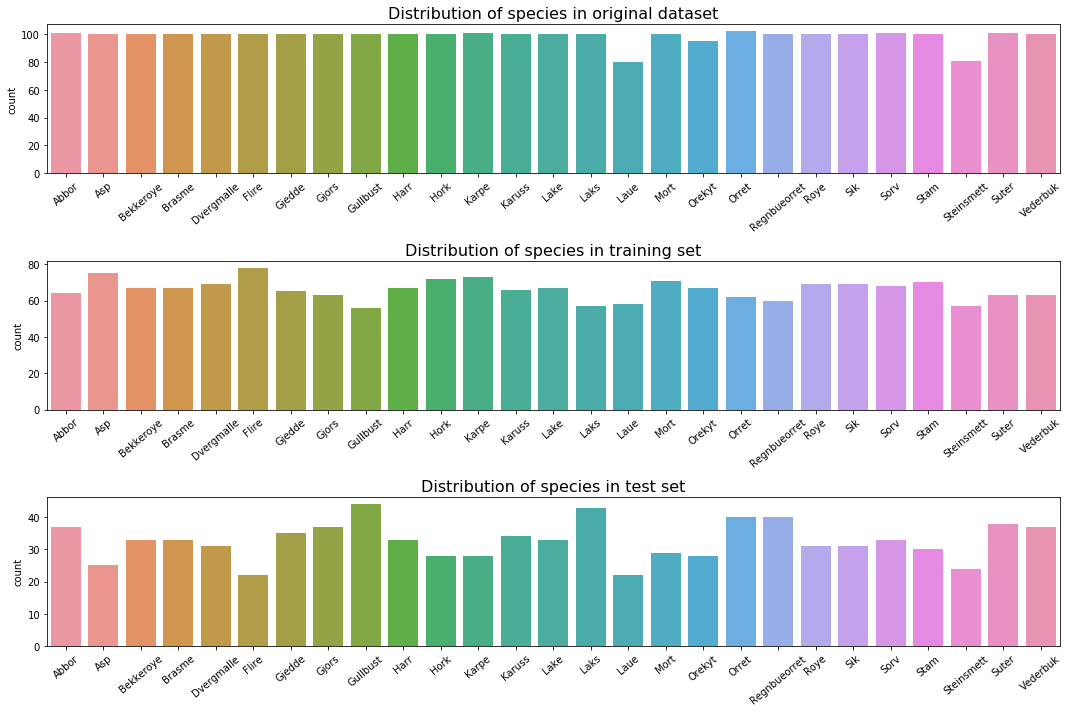

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
rot = 40

# Original full dataset
sns.countplot(fish_species, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = rot)
axes[0].set_title('Distribution of species in original dataset', fontsize=16)

# Training dataset
sns.countplot(revert_onehot_encode(Y_train), ax=axes[1])
axes[1].set_title('Distribution of species in training set', fontsize=16)
axes[1].set_xticklabels(np.unique(fish_species), rotation=rot)

# Test dataset
sns.countplot(revert_onehot_encode(Y_test), ax=axes[2])
axes[2].set_title('Distribution of species in test set', fontsize=16)
axes[2].set_xticklabels(np.unique(fish_species), rotation=rot)
plt.tight_layout()

### Model initialization
Mobile net implementation by transfer learning

In [19]:
# Create model
MobilenetFishrecModel = mobilnet_fish_recognition_model(X_train.shape[1:], n_fish=n_species) #, plot_to_file=True)
MobilenetFishrecModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

### Model fitting

In [20]:
# Create model
#MobilenetFishrecModel = mobilnet_fish_recognition_model(X_train.shape[1:])

# Choose optimizer- we choose the Adam optimizer as default
optim = Adam() # Some default args lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0

# Compile model 
MobilenetFishrecModel.compile(optimizer=optim, loss = "binary_crossentropy", metrics = ["accuracy"])

# Train model - The fit() method on a Keras Model returns a History object
history = MobilenetFishrecModel.fit(x = X_train, y = Y_train, epochs = 50, batch_size = 16)

# Evaluate model
preds = MobilenetFishrecModel.evaluate(x = X_test, y = Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

save_to = 'modelling/built_models/'
savename = 'MobilenetFishrecModel_noaug_300719'
save_keras_model(MobilenetFishrecModel, save_to + savename)

Epoch 1/50
1783/1783 [==============================] - 10s 6ms/step - loss: 0.1283 - acc: 0.9653
Epoch 2/50
1783/1783 [==============================] - 7s 4ms/step - loss: 0.0809 - acc: 0.9771
Epoch 3/50
1783/1783 [==============================] - 7s 4ms/step - loss: 0.0672 - acc: 0.9788
Epoch 4/50
1783/1783 [==============================] - 7s 4ms/step - loss: 0.0600 - acc: 0.9806
Epoch 5/50
1783/1783 [==============================] - 7s 4ms/step - loss: 0.0532 - acc: 0.9819
Epoch 6/50
1783/1783 [==============================] - 7s 4ms/step - loss: 0.0476 - acc: 0.9834
Epoch 7/50
1783/1783 [==============================] - 7s 4ms/step - loss: 0.0444 - acc: 0.9850
Epoch 8/50
1783/1783 [==============================] - 7s 4ms/step - loss: 0.0409 - acc: 0.9855
Epoch 9/50
1783/1783 [==============================] - 7s 4ms/step - loss: 0.0389 - acc: 0.9865
Epoch 10/50
1783/1783 [==============================] - 7s 4ms/step - loss: 0.0365 - acc: 0.9875
Epoch 11/50
1783/1783 [=====

### Save model

In [ ]:
# Save and load model 
#save_to = 'modelling/built_models/'
#savename = 'MobilenetFishrecModel_290719'
#save_keras_model(MobilenetFishrecModel, save_to + savename)
loaded_model = load_keras_model(save_to + savename)

### Model evaluation and error analysis

In [11]:
model = load_keras_model('modelling/built_models/MobilenetFishrecModel_noaug_300719')
#model = MobilenetFishrecModel
Y_test_prob = model.predict(x = X_test, verbose=1)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1_2/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@conv1_bn_2/cond/FusedBatchNorm/Switch"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1_2/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1_2/kernel/read)]]
	 [[{{node prediction_2/Sigmoid/_3131}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1033_prediction_2/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

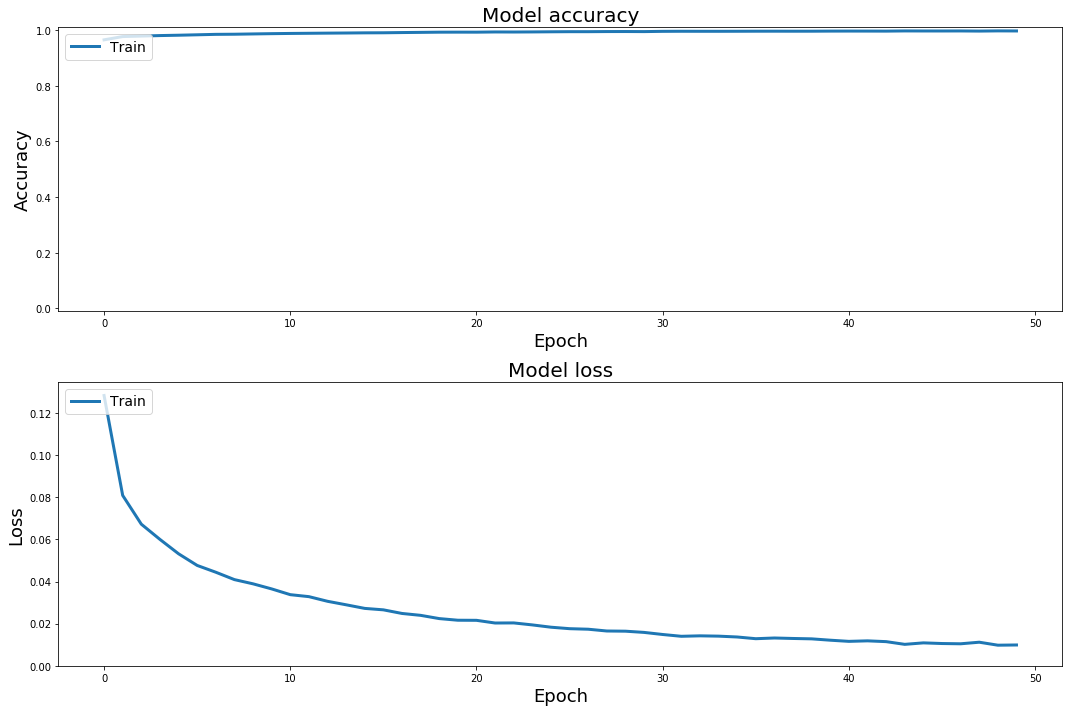

In [22]:
# Look at training accuracy and loss values over epochs
plot_keras_history(history, plotsize=5)

Confusion matrix, without normalization


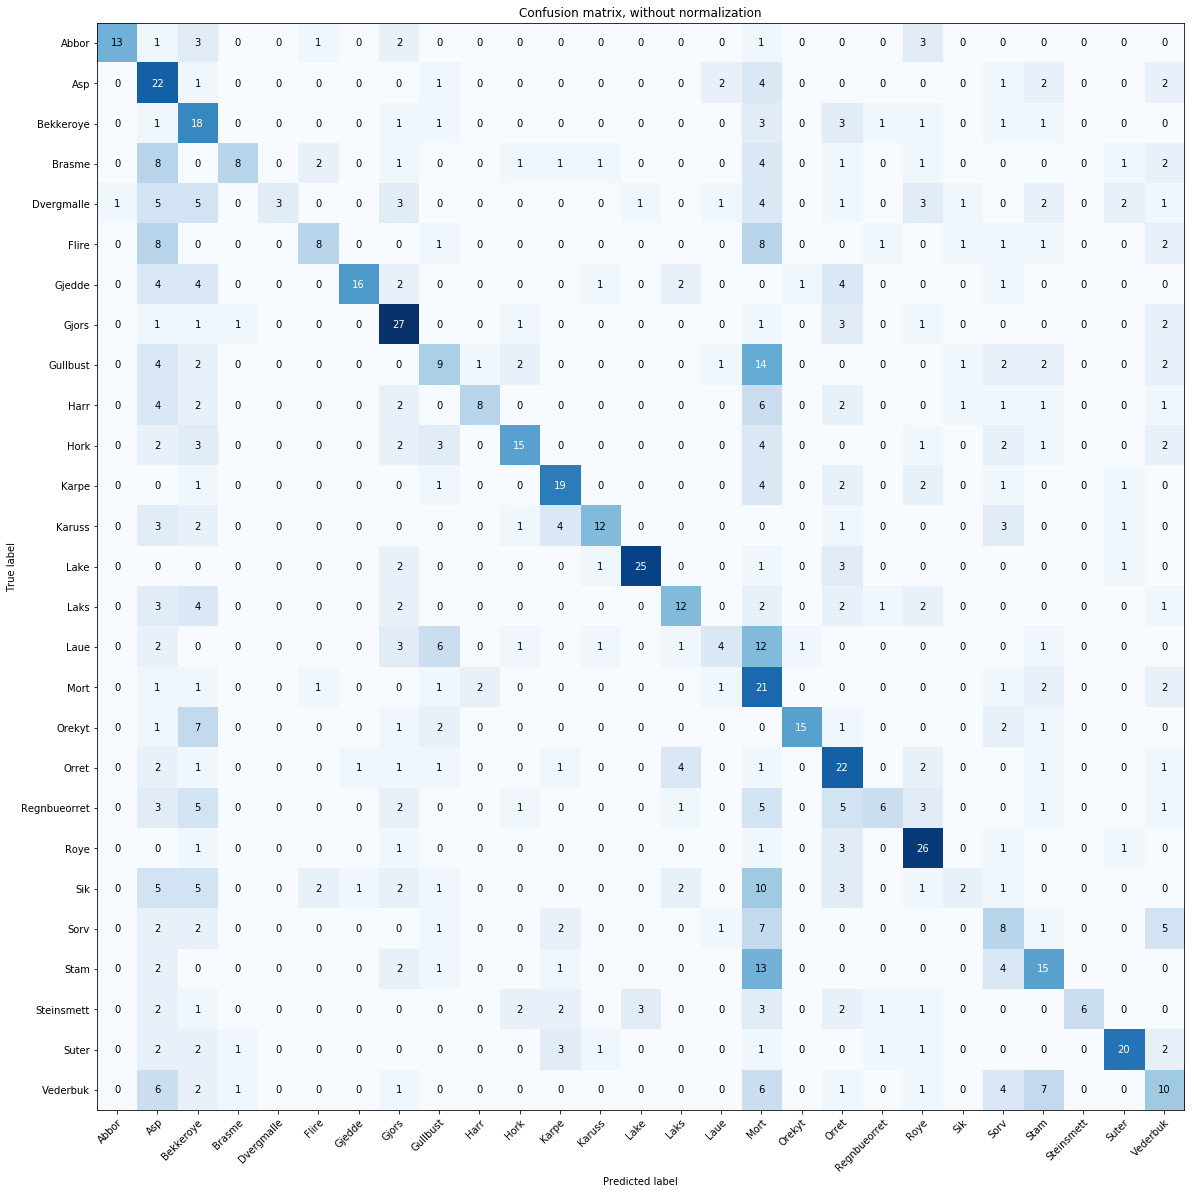

In [23]:
classes = np.array(list(fish_mapping.keys())[:n_species])
plot = plot_confusion_matrix(Y_test, Y_test_prob, classes)

In [2]:
(13+22+18+8+3+8+16+27+9+8+15+19+12+25+12+4+21+15+22+6+26+2+8+15+6+20+10)/879

0.42093287827076226

### Model explanation using LIME
Taken from [notebook in github repo](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb) of Lime.

In [76]:
def getKeysByValue(dictOfElements, valueToFind):
    """ Get a list of keys from dictionary which has the given value """
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return listOfKeys

def decode_fish_prediction(fish_map_dict, pred_probs_array, true_spec=''):
    if sum(pred_probs_array) != 1:
        pred_probs_array = pred_probs_array / (sum(pred_probs_array))
    sorted_indices = np.argsort(pred_probs_array)
    print("PREDICTIONS:")
    for i in range(1, 6):
        fish_ind = sorted_indices[-i]
        fish = getKeysByValue(fish_map_dict, fish_ind)
        print("   %s with probability %.4f" % (fish[0], pred_probs_array[fish_ind]))
        if i==1:
            predicted_fish = fish[0]
    if len(true_spec) > 0:
        if predicted_fish == true_spec:
            print("   CORRECT PREDICTION!")
        else:
            print("   WRONG PREDICTION...")

In [77]:
def plot_predictions_for_species(pred_prob_mat, true_spec_mat, img_tensor, fish_map, species='Abbor', n_lim=10):
    col = fish_map[species]
    true_spec_col = true_spec_mat[:, col]
    row_indexes_spec = np.where(true_spec_col == 1)[0]
    
    for i in range(min([n_lim, len(row_indexes_spec)])):
        ind = row_indexes_spec[i]
        
        print("TRUE SPECIES: %s" % getKeysByValue(fish_map, np.argmax(true_spec_mat[ind,:]))[0])
        #print(pred_prob_mat[ind,:])
        decode_fish_prediction(fish_map, pred_prob_mat[ind,:], true_spec=species)

        plt.figure(figsize=(6,6))
        plt.imshow(img_tensor[ind,:,:,:])
        plt.show()

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.3962
   Bekkeroye with probability 0.3875
   Mort with probability 0.1316
   Vederbuk with probability 0.0299
   Sorv with probability 0.0189
   CORRECT PREDICTION!


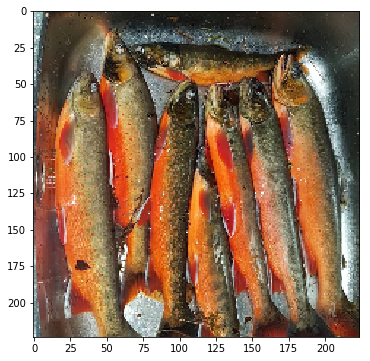

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.9203
   Sik with probability 0.0351
   Mort with probability 0.0153
   Bekkeroye with probability 0.0151
   Vederbuk with probability 0.0045
   CORRECT PREDICTION!


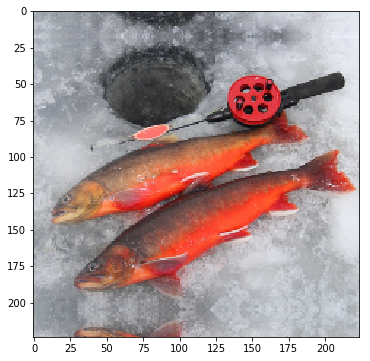

TRUE SPECIES: Roye
PREDICTIONS:
   Orret with probability 0.5231
   Asp with probability 0.2458
   Laks with probability 0.0594
   Mort with probability 0.0505
   Roye with probability 0.0310
   WRONG PREDICTION...


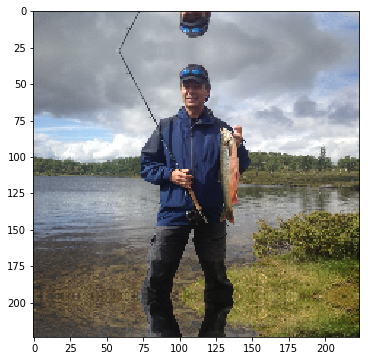

TRUE SPECIES: Roye
PREDICTIONS:
   Bekkeroye with probability 0.3404
   Orret with probability 0.3375
   Roye with probability 0.2883
   Gullbust with probability 0.0200
   Regnbueorret with probability 0.0082
   WRONG PREDICTION...


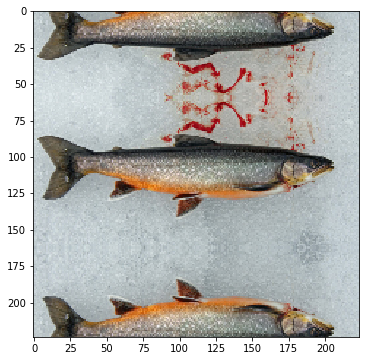

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.6337
   Bekkeroye with probability 0.3174
   Orret with probability 0.0205
   Asp with probability 0.0107
   Lake with probability 0.0077
   CORRECT PREDICTION!


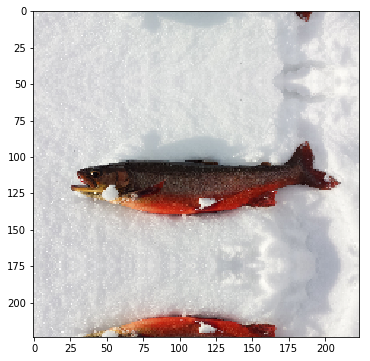

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.7382
   Bekkeroye with probability 0.2405
   Abbor with probability 0.0051
   Regnbueorret with probability 0.0046
   Mort with probability 0.0037
   CORRECT PREDICTION!


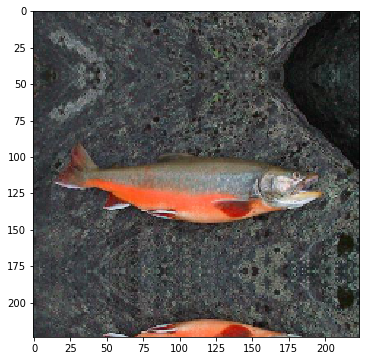

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.8216
   Mort with probability 0.1446
   Bekkeroye with probability 0.0165
   Gjors with probability 0.0040
   Sik with probability 0.0039
   CORRECT PREDICTION!


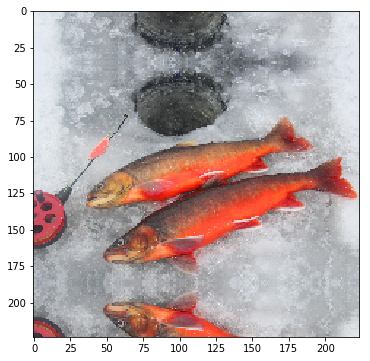

TRUE SPECIES: Roye
PREDICTIONS:
   Orret with probability 0.6427
   Regnbueorret with probability 0.2308
   Roye with probability 0.0710
   Asp with probability 0.0422
   Bekkeroye with probability 0.0055
   WRONG PREDICTION...


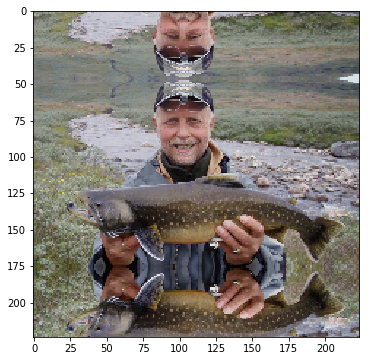

TRUE SPECIES: Roye
PREDICTIONS:
   Sorv with probability 0.3646
   Mort with probability 0.3325
   Roye with probability 0.1890
   Gjors with probability 0.0364
   Karpe with probability 0.0303
   WRONG PREDICTION...


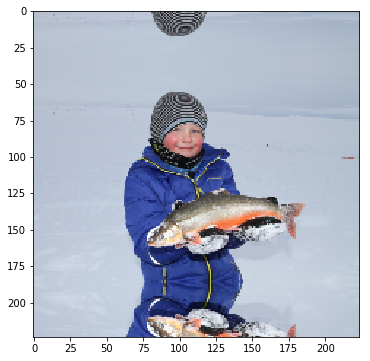

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.7395
   Bekkeroye with probability 0.1884
   Orret with probability 0.0580
   Suter with probability 0.0065
   Mort with probability 0.0041
   CORRECT PREDICTION!


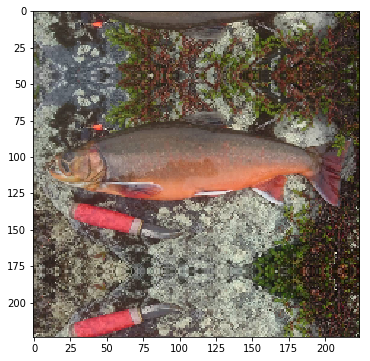

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.5869
   Vederbuk with probability 0.2226
   Gjors with probability 0.0755
   Sorv with probability 0.0530
   Karpe with probability 0.0216
   CORRECT PREDICTION!


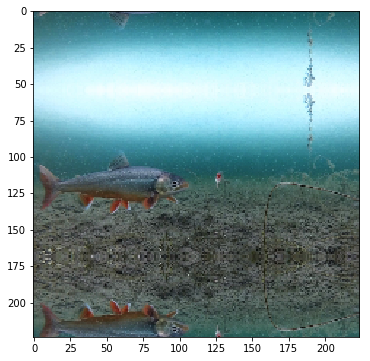

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.4930
   Bekkeroye with probability 0.4641
   Orret with probability 0.0232
   Asp with probability 0.0133
   Regnbueorret with probability 0.0033
   CORRECT PREDICTION!


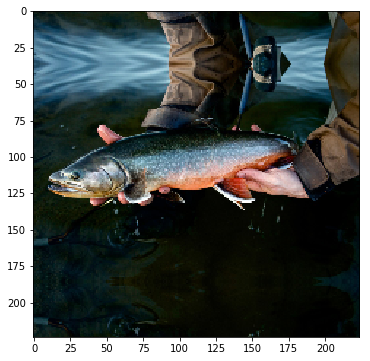

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.8113
   Gjors with probability 0.0815
   Asp with probability 0.0635
   Orret with probability 0.0260
   Laks with probability 0.0070
   CORRECT PREDICTION!


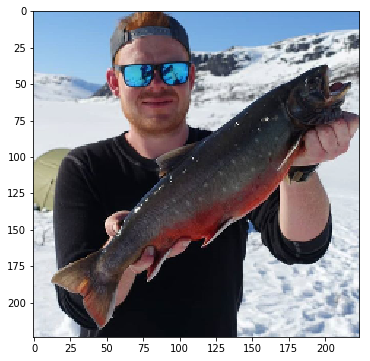

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.7850
   Orret with probability 0.1791
   Orekyt with probability 0.0104
   Mort with probability 0.0081
   Gullbust with probability 0.0044
   CORRECT PREDICTION!


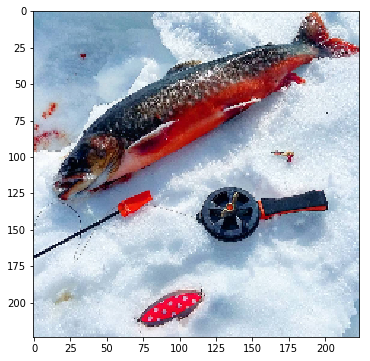

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.9132
   Bekkeroye with probability 0.0692
   Regnbueorret with probability 0.0096
   Abbor with probability 0.0032
   Mort with probability 0.0011
   CORRECT PREDICTION!


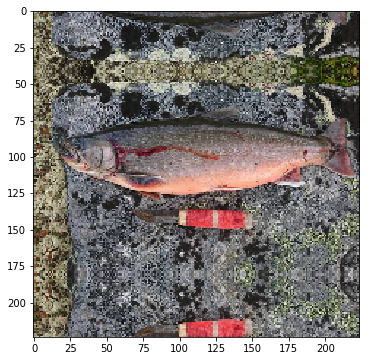

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.7292
   Sorv with probability 0.1401
   Mort with probability 0.0660
   Karpe with probability 0.0387
   Orret with probability 0.0108
   CORRECT PREDICTION!


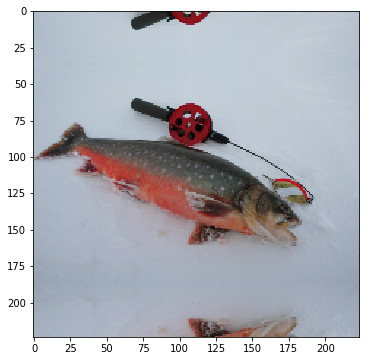

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.5790
   Bekkeroye with probability 0.3354
   Regnbueorret with probability 0.0336
   Karpe with probability 0.0213
   Suter with probability 0.0140
   CORRECT PREDICTION!


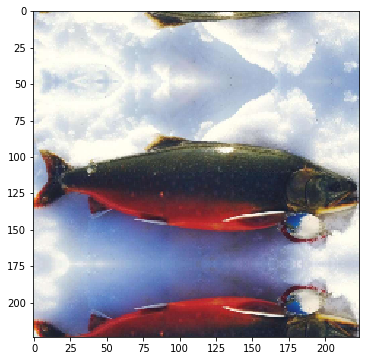

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.6684
   Abbor with probability 0.1857
   Karpe with probability 0.0587
   Hork with probability 0.0386
   Bekkeroye with probability 0.0264
   CORRECT PREDICTION!


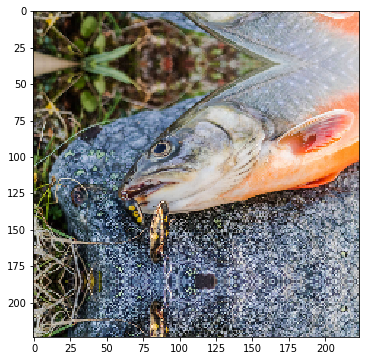

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.6074
   Regnbueorret with probability 0.2842
   Bekkeroye with probability 0.0521
   Karpe with probability 0.0274
   Orret with probability 0.0232
   CORRECT PREDICTION!


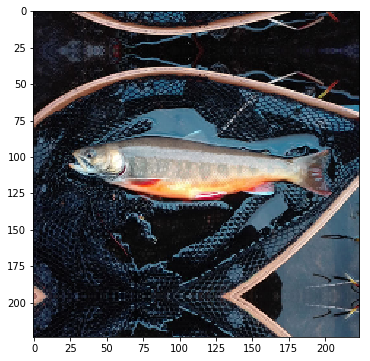

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.4340
   Bekkeroye with probability 0.2004
   Orret with probability 0.1640
   Mort with probability 0.1433
   Sorv with probability 0.0313
   CORRECT PREDICTION!


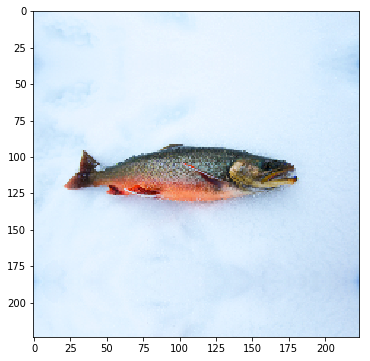

TRUE SPECIES: Roye
PREDICTIONS:
   Gjors with probability 0.4427
   Roye with probability 0.3392
   Asp with probability 0.1258
   Laks with probability 0.0783
   Mort with probability 0.0107
   WRONG PREDICTION...


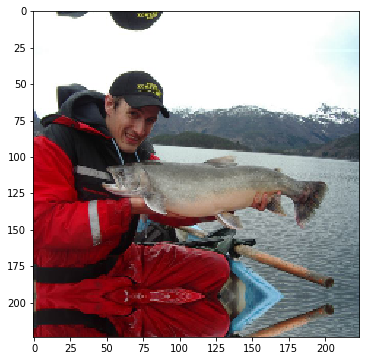

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.3918
   Sorv with probability 0.2014
   Bekkeroye with probability 0.1269
   Stam with probability 0.1261
   Regnbueorret with probability 0.0945
   CORRECT PREDICTION!


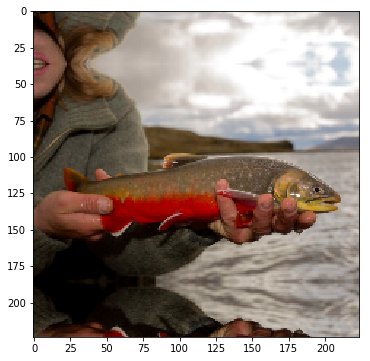

TRUE SPECIES: Roye
PREDICTIONS:
   Mort with probability 0.4232
   Asp with probability 0.3257
   Bekkeroye with probability 0.1078
   Vederbuk with probability 0.0320
   Roye with probability 0.0310
   WRONG PREDICTION...


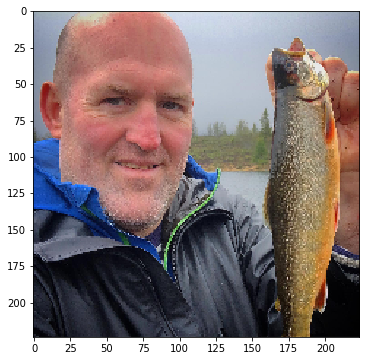

TRUE SPECIES: Roye
PREDICTIONS:
   Suter with probability 0.6735
   Roye with probability 0.2048
   Orret with probability 0.0703
   Asp with probability 0.0294
   Mort with probability 0.0112
   WRONG PREDICTION...


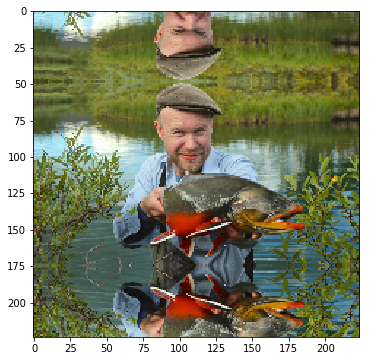

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.6873
   Regnbueorret with probability 0.2123
   Vederbuk with probability 0.0493
   Gjors with probability 0.0321
   Asp with probability 0.0102
   CORRECT PREDICTION!


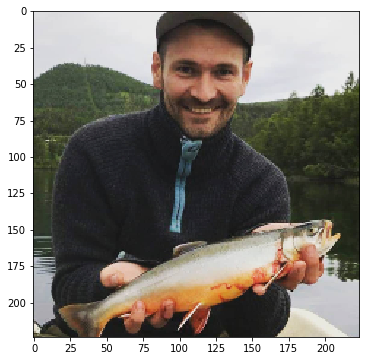

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.5031
   Gjors with probability 0.4485
   Orret with probability 0.0169
   Regnbueorret with probability 0.0100
   Bekkeroye with probability 0.0083
   CORRECT PREDICTION!


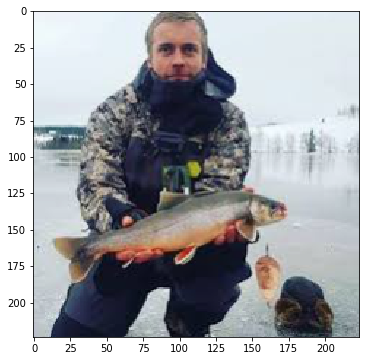

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.6272
   Bekkeroye with probability 0.3209
   Hork with probability 0.0236
   Orret with probability 0.0152
   Mort with probability 0.0035
   CORRECT PREDICTION!


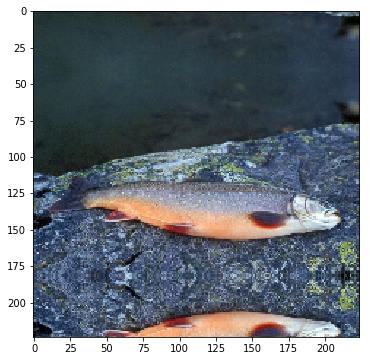

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.8570
   Regnbueorret with probability 0.0601
   Hork with probability 0.0256
   Vederbuk with probability 0.0241
   Bekkeroye with probability 0.0094
   CORRECT PREDICTION!


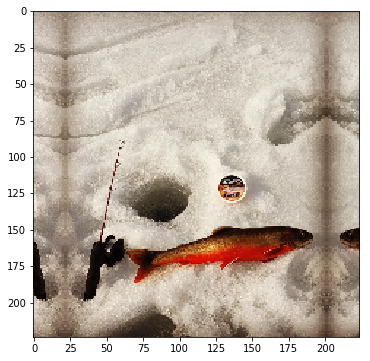

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.8511
   Bekkeroye with probability 0.0727
   Orret with probability 0.0303
   Mort with probability 0.0260
   Asp with probability 0.0106
   CORRECT PREDICTION!


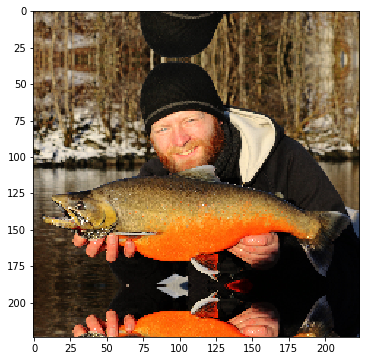

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.3897
   Bekkeroye with probability 0.3147
   Mort with probability 0.2069
   Sik with probability 0.0410
   Orret with probability 0.0301
   CORRECT PREDICTION!


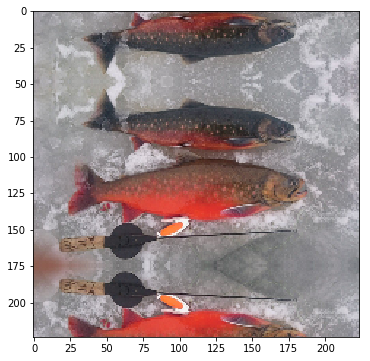

TRUE SPECIES: Roye
PREDICTIONS:
   Orret with probability 0.3910
   Roye with probability 0.3101
   Bekkeroye with probability 0.2604
   Mort with probability 0.0257
   Regnbueorret with probability 0.0043
   WRONG PREDICTION...


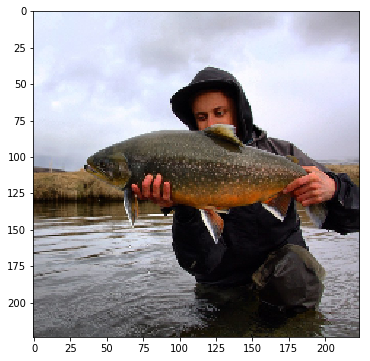

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.3435
   Laks with probability 0.2952
   Orret with probability 0.2768
   Bekkeroye with probability 0.0514
   Stam with probability 0.0166
   CORRECT PREDICTION!


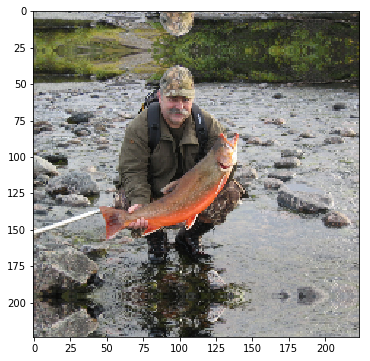

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.6272
   Bekkeroye with probability 0.3209
   Hork with probability 0.0236
   Orret with probability 0.0152
   Mort with probability 0.0035
   CORRECT PREDICTION!


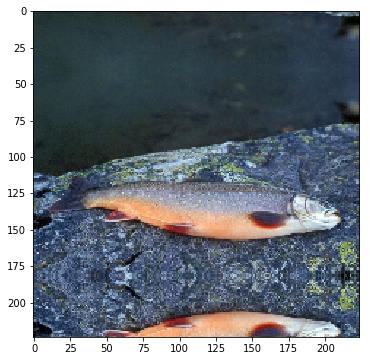

TRUE SPECIES: Roye
PREDICTIONS:
   Roye with probability 0.7458
   Bekkeroye with probability 0.1827
   Regnbueorret with probability 0.0347
   Orret with probability 0.0205
   Suter with probability 0.0120
   CORRECT PREDICTION!


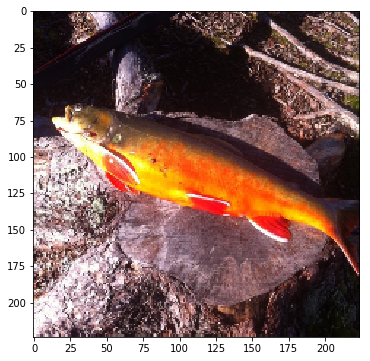

In [81]:
plot_predictions_for_species(Y_test_prob, Y_test, X_test, fish_mapping, 
                             species='Roye', n_lim=100)

TRUE SPECIES: Abbor
PREDICTIONS:
   Roye with probability 0.7913
   Suter with probability 0.0884
   Laks with probability 0.0634
   Bekkeroye with probability 0.0190
   Orret with probability 0.0186


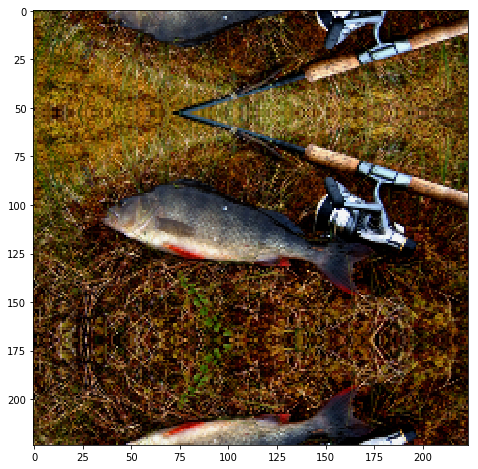

In [50]:
ind = 57

print("TRUE SPECIES: %s" % getKeysByValue(fish_mapping, np.argmax(Y_test[ind,:]))[0])
decode_fish_prediction(fish_mapping, Y_test_prob[ind,:])

plt.figure(figsize=(8,8))
plt.imshow(X_test[ind,:,:,:])
plt.show()

In [76]:
explainer = lime_image.LimeImageExplainer()

In [77]:
help(explainer.explain_instance)

Help on method explain_instance in module lime.lime_image:

explain_instance(image, classifier_fn, labels=(1,), hide_color=None, top_labels=5, num_features=100000, num_samples=1000, batch_size=10, segmentation_fn=None, distance_metric='cosine', model_regressor=None, random_seed=None) method of lime.lime_image.LimeImageExplainer instance
    Generates explanations for a prediction.
    
    First, we generate neighborhood data by randomly perturbing features
    from the instance (see __data_inverse). We then learn locally weighted
    linear models on this neighborhood data to explain each of the classes
    in an interpretable way (see lime_base.py).
    
    Args:
        image: 3 dimension RGB image. If this is only two dimensional,
            we will assume it's a grayscale image and call gray2rgb.
        classifier_fn: classifier prediction probability function, which
            takes a numpy array and outputs prediction probabilities.  For
            ScikitClassifiers , this 

In [78]:
%%time
"""
Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, 
the superpixel will be replaced by the average of its pixels
"""
explanation = explainer.explain_instance(X_test[ind,:,:,:], model.predict, hide_color=0, num_samples=10)

AttributeError: module 'sklearn' has no attribute 'metrics'